# Conditional Least-Square DCGAN

In this experiment, we will see the effect of Least-Square loss on Conditional DCGAN. We saw that Least-Square loss makes the Generator unstable even after learning to generate good images. We would see if the effect continues with the Conditional DCGAN.

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


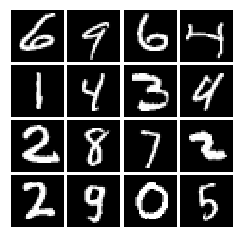

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

In [4]:
def sample_labels(batch_size, dim):
    """Generate one hot random labels.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing one-hot labels with shape [batch_size, dim]
    """
    labels = tf.random_uniform([batch_size, dim], 0, 1)
    return tf.one_hot(tf.argmax(labels, axis=1), dim)

## Discriminator

We use the labels in the discriminator only at the fully connected layer. This is the trick that I learnt from [Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) algorithm where the put the continuous actions only near the last layer.

In [5]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images along with its labels, shape [batch_size, 784 + 10]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        batch_size = tf.shape(x)[0]
        x_image = x[:, :784]
        x_label = x[:, 784:]
        x_image = tf.reshape(x_image, (batch_size, 28, 28, 1), name="reshape_3d")
        conv_1 = tf.layers.conv2d(x_image, filters=32, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_1")
        pool_1 = tf.layers.max_pooling2d(conv_1, pool_size=(2, 2), strides=2, name="pool_1")
        conv_2 = tf.layers.conv2d(pool_1, filters=64, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_2")
        pool_2 = tf.layers.max_pooling2d(conv_2, pool_size=(2, 2), strides=2, name="pool_2")
        flatten = tf.reshape(pool_2, shape=(batch_size, 64 * 16))
        flatten_label = tf.concat((flatten, x_label), axis=1)
        fc_1 = tf.layers.dense(flatten_label, 1024, name="fc_1", activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(fc_1, 1, name="logits")
        return logits

## Generator

In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim + label_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.layers.dense(bn1, 7 * 7 * 128, tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2)
        image_tensor = tf.reshape(bn2, (tf.shape(z)[0], 7, 7, 128))
        conv_T_1 = tf.layers.conv2d_transpose(image_tensor, filters=64, kernel_size=(4, 4), 
                                              strides=(2, 2), padding="same", activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(conv_T_1)
        conv_T_2 = tf.layers.conv2d_transpose(bn3, filters=1, kernel_size=(4, 4), strides=(2, 2), 
                                               padding="same", activation=tf.nn.tanh)
        img = tf.reshape(conv_T_2, (-1,784))
    return img

## Conditon Least-Square DCGAN Loss

In [7]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss = 0.5 * (tf.reduce_mean((score_real - 1) ** 2) + tf.reduce_mean(score_fake ** 2))
    G_loss = 0.5 * tf.reduce_mean((score_fake - 1) ** 2)
    return D_loss, G_loss

# Optimizing our loss

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
labels_dim = 10

# placeholder for images from the training dataset
x_image = tf.placeholder(tf.float32, [None, 784])
# scale images to be -1 to 1
x_image_preprocess = preprocess_img(x_image)
# placeholders for labels
x_label = tf.placeholder(tf.float32, [None, labels_dim])
# concate labels and images
x = tf.concat((x_image_preprocess, x_label), axis=1)

# random image_noise fed into our generator
z_image = sample_noise(batch_size, noise_dim)
# random label_nose fed into the generator
z_label = sample_labels(batch_size, labels_dim)
# concat image and noise
z = tf.concat((z_image, z_label), axis=1)

# generated images
G_sample = generator(z)
# concat generated images with fake labels
G_sample_with_labels = tf.concat((G_sample, z_label), axis=1)

with tf.variable_scope("") as scope:
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample_with_labels)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!

In [10]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x_image: minibatch_x,
                                                                     x_label: minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

## Train Conditional DCGAN! 

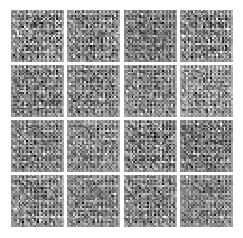


Iter: 0, D: 0.7171, G:0.385
Iter: 50, D: 0.05203, G:0.4961
Iter: 100, D: 0.06226, G:0.5103
Iter: 150, D: 0.02465, G:0.6044
Iter: 200, D: 0.1021, G:0.924


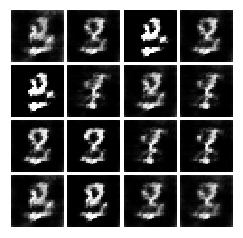


Iter: 250, D: 0.04277, G:0.4161
Iter: 300, D: 0.04989, G:0.5201
Iter: 350, D: 0.06378, G:0.4456
Iter: 400, D: 0.05302, G:0.4995
Iter: 450, D: 0.05709, G:0.4466


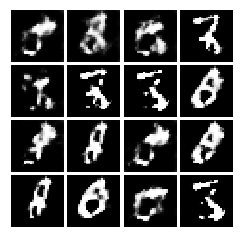


Iter: 500, D: 0.05579, G:0.5313
Iter: 550, D: 0.1534, G:0.1272
Iter: 600, D: 0.1132, G:0.6408
Iter: 650, D: 0.1567, G:0.6486
Iter: 700, D: 0.1386, G:0.237


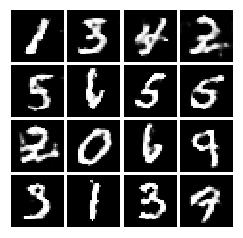


Iter: 750, D: 0.288, G:0.7006
Iter: 800, D: 0.1532, G:0.263
Iter: 850, D: 0.2005, G:0.2987
Iter: 900, D: 0.1915, G:0.2681
Iter: 950, D: 0.1928, G:0.2604


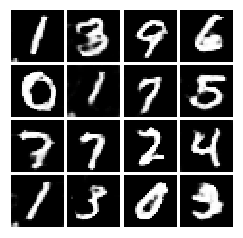


Iter: 1000, D: 0.1908, G:0.2838
Iter: 1050, D: 0.1744, G:0.2366
Iter: 1100, D: 0.1975, G:0.17
Iter: 1150, D: 0.1868, G:0.2493
Iter: 1200, D: 0.1989, G:0.2452


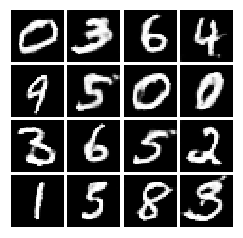


Iter: 1250, D: 0.2146, G:0.1595
Iter: 1300, D: 0.2013, G:0.2592
Iter: 1350, D: 0.1773, G:0.2348
Iter: 1400, D: 0.2109, G:0.2058
Iter: 1450, D: 0.1992, G:0.2161


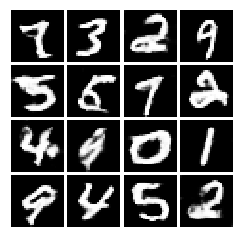


Iter: 1500, D: 0.2018, G:0.1489
Iter: 1550, D: 0.2118, G:0.1955
Iter: 1600, D: 0.2132, G:0.1986
Iter: 1650, D: 0.1842, G:0.2242
Iter: 1700, D: 0.1908, G:0.2355


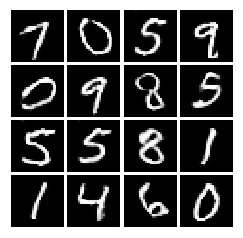


Iter: 1750, D: 0.1799, G:0.2539
Iter: 1800, D: 0.1837, G:0.2053
Iter: 1850, D: 0.1764, G:0.2443
Iter: 1900, D: 0.2799, G:0.1392
Iter: 1950, D: 0.1871, G:0.1846


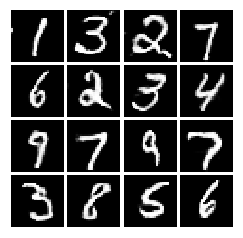


Iter: 2000, D: 0.2335, G:0.2373
Iter: 2050, D: 0.1898, G:0.2245
Iter: 2100, D: 0.36, G:0.08149
Iter: 2150, D: 0.2063, G:0.1262
Iter: 2200, D: 0.1817, G:0.1923


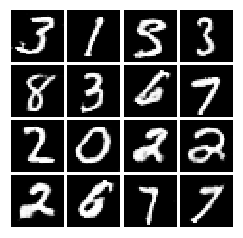


Iter: 2250, D: 0.2135, G:0.1983
Iter: 2300, D: 0.1986, G:0.1733
Iter: 2350, D: 0.2044, G:0.2395
Iter: 2400, D: 0.213, G:0.1179
Iter: 2450, D: 0.2169, G:0.2714


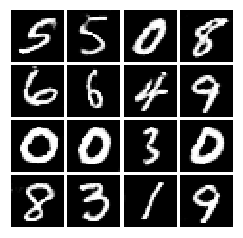


Iter: 2500, D: 0.1911, G:0.2072
Iter: 2550, D: 0.2016, G:0.232
Iter: 2600, D: 0.2214, G:0.3045
Iter: 2650, D: 0.213, G:0.2138
Iter: 2700, D: 0.2145, G:0.2447


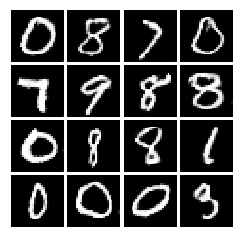


Iter: 2750, D: 0.2195, G:0.2133
Iter: 2800, D: 0.2101, G:0.1841
Iter: 2850, D: 0.2054, G:0.1764
Iter: 2900, D: 0.182, G:0.1917
Iter: 2950, D: 0.2103, G:0.1493


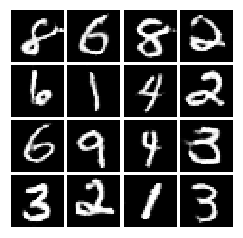


Iter: 3000, D: 0.1991, G:0.229
Iter: 3050, D: 0.2147, G:0.4313
Iter: 3100, D: 0.1782, G:0.196
Iter: 3150, D: 0.2116, G:0.1881
Iter: 3200, D: 0.1965, G:0.2744


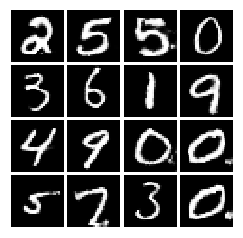


Iter: 3250, D: 0.1832, G:0.3446
Iter: 3300, D: 0.2279, G:0.4232
Iter: 3350, D: 0.1705, G:0.2714
Iter: 3400, D: 0.1978, G:0.2477
Iter: 3450, D: 0.1759, G:0.2048


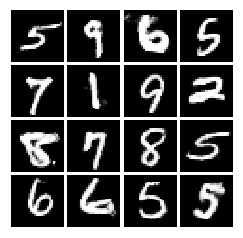


Iter: 3500, D: 0.182, G:0.2575
Iter: 3550, D: 0.1831, G:0.1292
Iter: 3600, D: 0.2028, G:0.3422
Iter: 3650, D: 0.2086, G:0.09416
Iter: 3700, D: 0.1947, G:0.201


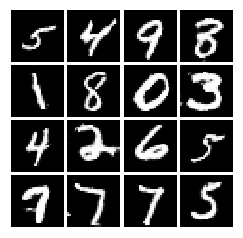


Iter: 3750, D: 0.1833, G:0.1345
Iter: 3800, D: 0.202, G:0.1132
Iter: 3850, D: 0.1747, G:0.1942
Iter: 3900, D: 0.1595, G:0.2278
Iter: 3950, D: 0.1797, G:0.183


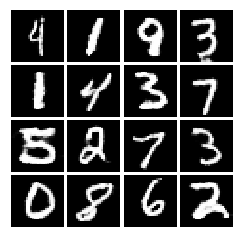


Iter: 4000, D: 0.1701, G:0.1559
Iter: 4050, D: 0.1712, G:0.1787
Iter: 4100, D: 0.17, G:0.182
Iter: 4150, D: 0.1694, G:0.2357
Iter: 4200, D: 0.1855, G:0.2765


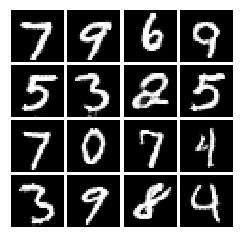


Iter: 4250, D: 0.197, G:0.1416
Final images


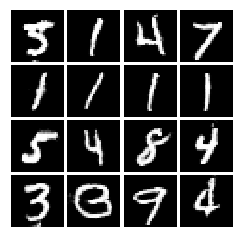

In [11]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Conclusion

Generated images look fine. But we see some images that look the intersection of two images such as in the final image above, there is an image (last row second column) that looks like a middle image between $3$ and $8$.

# Showing that Conditional DCGAN is able to generate the similar looking images by using the labels

In [12]:
def get_fixed_labels(batch_size, label_num):
    """
    Generate the labels to use in the Conditional GAN
    """
    labels = np.zeros((batch_size, 10))
    labels[np.arange(batch_size), label_num] = 1
    return labels

### Generating samples similar to digit $7$

** In the below code, I am using the trick that you can pass values to a tensorflow variables**

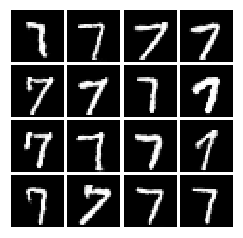

In [13]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 7)})
fig = show_images(samples[:16])
plt.show()

** Conclusion:** As previously, All of these images of$7$ looks fine to me.

### Generating samples similar to digit $3$

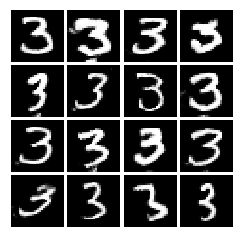

In [14]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 3)})
fig = show_images(samples[:16])
plt.show()